In [314]:
import sys
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, average_precision_score
from sklearn.preprocessing import label_binarize
%matplotlib inline
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy.random as rnd
import numpy as np
import matplotlib
import seaborn as sns
from itertools import groupby

In [315]:
def average_precision(y_true, y_score):
    correct_label = 0
    ap = 0
    for n, (true, score) in enumerate(zip(y_true, y_score), start=1):
        if true == 1:
            correct_label += 1
            ap += (correct_label * 1.0 / n)
    return ap / correct_label

In [354]:
print(train_X[2:10])
print(train_y[2:10])

[[  1.           9.12961712]
 [  2.          15.60834245]
 [  2.          18.25923423]
 [  2.          16.81887265]
 [  0.           0.        ]
 [  2.          16.81887265]
 [  1.           7.97693761]
 [  2.          16.81887265]]
[0 1 0 0 0 0 0 0]


# そのまま

# 訓練

In [337]:
train_y = np.array([int(x.split("\t")[1]) for x in open("../data/WikiQACorpus/train.features")])
train_X = np.array([[float(x.split("\t")[2]), float(x.split("\t")[3])] for x in open("../data/WikiQACorpus/train.features") ])

model = LogisticRegression()
model.fit(X=train_X[:,1].reshape(-1, 1), y=train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# 評価

In [349]:
# devデータのロード
lis = []
with open("../data/WikiQACorpus/test.features", "r") as fi:
    for q_id, section in groupby(fi, key=lambda x: x.split("\t")[0]):
        section = list(section)
        random.shuffle(section)
        test_y = np.array([x.strip().split("\t")[1] for x in section], dtype=np.int32)
        test_X = np.array([x.strip().split("\t")[3] for x in section], dtype=np.float32).reshape(-1, 1)
        pred = model.predict_proba(X=test_X)[:,1]
        x = np.c_[test_y, pred]
        order = x[:,1].argsort()[::-1]
        true_labels = x[order][:,0]
        scores = x[order][:,1]
        lis.append(average_precision(y_score=scores, y_true=true_labels))
        
        #lis.append(average_precision_score(y_score=pred[:,1], y_true=test_y))
print(np.mean(lis))

0.512826212538


# 松林さん手法

In [318]:
train_y = np.array([int(x.split("\t")[1]) for x in open("../data/WikiQACorpus/train.features")], dtype=np.int32)
train_X = np.array([[float(x.split("\t")[2]), float(x.split("\t")[3])] for x in open("../data/WikiQACorpus/train.features") ], dtype=np.float32)

model = LogisticRegression()
# binarize
train_X = label_binarize(train_X[:,0], classes=list(range(50)))
model.fit(X=train_X, y=train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [328]:
# devデータのロード
lis = []
with open("../data/WikiQACorpus/test.features", "r") as fi:
    for q_id, section in groupby(fi, key=lambda x: x.split("\t")[0]):
        section = list(section)
        random.shuffle(section)
        
        test_y = np.array([x.strip().split("\t")[1] for x in section], dtype=np.int32)
        test_X = np.array([x.strip().split("\t")[2] for x in section], dtype=np.float32)
        test_X = label_binarize(test_X, classes=list(range(50)))
        
        
        #print(sorted(list(zip(model.predict_proba(X=test_X)[:,1], test_y)), key=lambda x:x[0], reverse=True))
        pred = model.predict_proba(X=test_X)[:,1]
        x = np.c_[test_y, pred]
        order = x[:,1].argsort()[::-1]
        true_labels = x[order][:,0]
        scores = x[order][:,1]
        lis.append(average_precision(y_score=scores, y_true=true_labels))

In [329]:
np.mean(lis)

0.55537600781489516

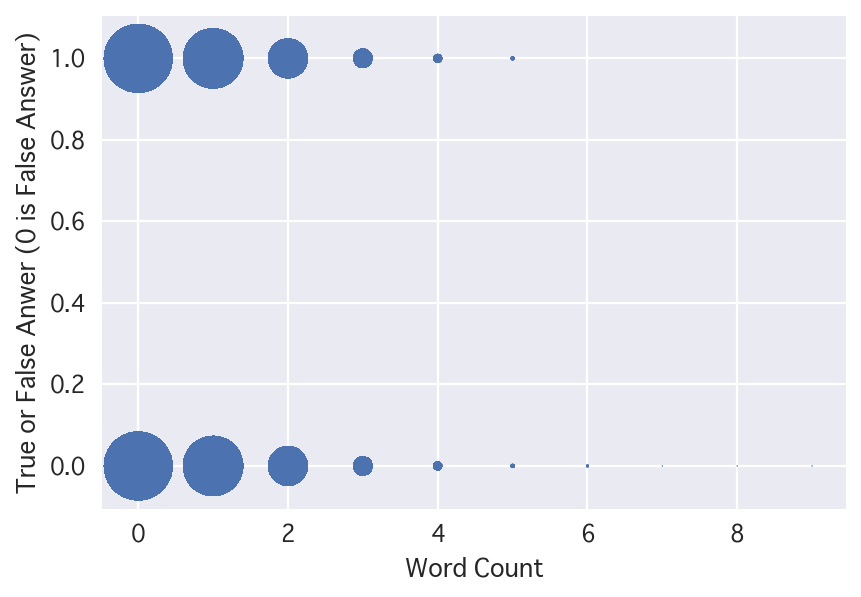

In [395]:
X = train_X[:,0]
y = train_y
df = pd.concat([pd.DataFrame(X), pd.DataFrame(y)], axis=1)
df.columns = ["X", "Y"]
counts = df["X"].value_counts()
df["count"] = df["X"].map(counts)
df.plot(kind='scatter', x='X', y='Y', s=df["count"] * 0.1)
plt.xlabel("Word Count")
plt.ylabel("True or False Anwer (0 is False Answer)")